In [1]:
# Packages for model learning
import numpy as np
import sklearn.metrics
import pandas as pd
import sklearn.model_selection

import torch
import torchvision
import gpytorch
import botorch

# Packages for data loading
import json
from pathlib import Path

/home/sentr/bin/miniconda/envs/gpytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Packages for Jupyter notebook
import IPython.display as ipd
import matplotlib.pyplot as plt
import PIL
import base64

In [3]:
from functools import cache

tensor_to_image = torchvision.transforms.ToPILImage()
@cache
def tensor_to_url(tensor, size=128):
    return fr"data:image/png;base64,{base64.b64encode(PIL.ImageOps.contain(tensor_to_image(tensor), (size, size))._repr_png_()).decode('ascii')}"

# Load and process data

In [5]:
# Make all photos square
def pad_image(img):
    h,w = img.shape[1:]
    if h != w:
        new_w = max(h,w)
        pad_h, rem_h = divmod(new_w - h, 2)
        pad_w, rem_w = divmod(new_w - w, 2)
        padding = [pad_w, pad_h, pad_w+rem_w, pad_h+rem_h]
        return torchvision.transforms.functional.pad(img, padding, padding_mode='edge')
    return img

In [6]:
# Load dataset

# img_root = './dataset/dress_pure_renamed/'
# train_metadata = json.loads(Path('./dataset/dress_pure_renamed/train.json').read_text())
# test_metadata = json.loads(Path('./dataset/dress_pure_renamed/test.json').read_text())
# val_metadata = json.loads(Path('./dataset/dress_pure_renamed/val.json').read_text())

# class_labels = ['christian_dior', 'maison_margiela']
torch.manual_seed(0)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

img_root = Path('./dataset/')
train_metadata = json.loads((img_root / 'train.json').read_text())
test_metadata = json.loads((img_root / 'test.json').read_text())
val_metadata = json.loads((img_root / 'val.json').read_text())

class_labels = ["alexander_mcqueen","donatella_versace","karl_lagerfeld","yves_saint_laurent"]
class_labels = [x.replace('_',' ') for x in class_labels]

n_train = len(train_metadata)
n_test = len(test_metadata)
n_val = len(val_metadata)
n_all = n_train + n_test + n_val

all_classes = torch.empty(n_all, dtype=torch.int)
all_images = [None]*n_all
for i,meta in enumerate((*train_metadata, *test_metadata, *val_metadata)):
    all_classes[i] = meta['label']
    all_images[i] = torchvision.io.read_image(str(img_root / meta['file_path'].replace('_pure','')))
    all_images[i] = pad_image(torchvision.transforms.functional.resize(all_images[i], 512, antialias=True))

In [7]:
n_classes = all_classes.max() + 1

In [8]:
from resnet_model import resnet_model

In [9]:
resnet_extractor = resnet_model(5,backbone="resnet18")
checkpoint = torch.load('results/fashion_designers.3layer.bsz_128sz_224.sgd0.002/best_model.pt', map_location=device)
resnet_extractor.load_state_dict(checkpoint['state_dict'])

/home/sentr/bin/miniconda/envs/gpytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sentr/bin/miniconda/envs/gpytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [10]:
for p in resnet_extractor.parameters():
    p.requires_grad = False

In [11]:
# Define resnet feature extractor
resnet_input_transform = torchvision.models.ResNet18_Weights.DEFAULT.transforms()
crop_size = resnet_input_transform.crop_size[0]

all_data = torch.empty(n_all, 3, crop_size, crop_size).to(device)
for i in range(n_all):
    all_data[i] = resnet_input_transform(all_images[i])

/home/sentr/bin/miniconda/envs/gpytorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [12]:
all_embeddings = resnet_extractor.backbone(all_data)

# Split train/test

In [13]:
kfold = sklearn.model_selection.KFold(5, shuffle=True, random_state=0)

In [14]:
idx_splits = list(kfold.split(np.empty(len(all_classes)), all_classes))
n_folds = len(idx_splits)

In [15]:
n_seed_rounds = 5

In [16]:
seed_round_index = pd.RangeIndex(n_seed_rounds, name='seed_i')
fold_index = pd.RangeIndex(n_folds, name='fold_i')

In [17]:
latent_dim_index = pd.Index([2,5,10], name='dim_i')

# Define and train GP

In [18]:
class DirichletGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes, latent_dim):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )
        self.scaler = gpytorch.utils.grid.ScaleToBounds(-1,1)
        self.fc = torch.nn.Linear(train_x.shape[1],latent_dim)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def transform(self, x):
        x = self.fc(x)
        x = self.scaler(x)
        return x

    def forward(self, x):
        x = self.transform(x)
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def embedding_posterior(self, z):
        '''Compute the posterior over z = self.transform(x)'''
        assert self.prediction_strategy is not None
        fz_mean = self.mean_module(z)
        Kz = self.covar_module(z)
        Kzx = self.covar_module(z, self.transform(self.train_inputs[0]))
        return gpytorch.distributions.MultivariateNormal(
            self.prediction_strategy.exact_predictive_mean(fz_mean,Kzx),
            self.prediction_strategy.exact_predictive_covar(Kz, Kzx)
        )

In [19]:
gp_index = pd.MultiIndex.from_product([fold_index, seed_round_index, latent_dim_index])

optimization_trace = pd.Series([list() for _ in gp_index], index=gp_index)
models = pd.Series(index=gp_index, dtype=object)

for gp_i in gp_index:
    print(gp_i,'...', end=' ', flush=True)
    fold_i, seed_i, dim_i = gp_i
    train_idx, test_idx = idx_splits[fold_i]
    train_classes = all_classes[train_idx]
    train_embeddings = all_embeddings[train_idx]

    test_classes = all_classes[test_idx]
    test_embeddings = all_embeddings[test_idx]

    # initialize likelihood and model
    torch.manual_seed(seed_i)

    likelihood = gpytorch.likelihoods.DirichletClassificationLikelihood(train_classes.long(), learn_additional_noise=True)
    model = DirichletGPModel(train_embeddings, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes, latent_dim=dim_i)

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    mll.train()
    botorch.optim.fit.fit_gpytorch_mll_torch(mll, step_limit=1000, optimizer=lambda p: torch.optim.Adam(p, lr=0.01), callback=lambda _,i: optimization_trace[gp_i].append(i))
    models[gp_i] = model
    print('Done', flush=True)
    # botorch.optim.fit.fit_gpytorch_mll_scipy(mll, callback=lambda _,i: optimization_trace.append(i))

(0, 0, 2) ... Done
(0, 0, 5) ... Done
(0, 0, 10) ... Done
(0, 1, 2) ... Done
(0, 1, 5) ... Done
(0, 1, 10) ... Done
(0, 2, 2) ... Done
(0, 2, 5) ... Done
(0, 2, 10) ... Done
(0, 3, 2) ... Done
(0, 3, 5) ... Done
(0, 3, 10) ... Done
(0, 4, 2) ... Done
(0, 4, 5) ... Done
(0, 4, 10) ... Done
(1, 0, 2) ... Done
(1, 0, 5) ... Done
(1, 0, 10) ... Done
(1, 1, 2) ... Done
(1, 1, 5) ... Done
(1, 1, 10) ... Done
(1, 2, 2) ... Done
(1, 2, 5) ... Done
(1, 2, 10) ... Done
(1, 3, 2) ... Done
(1, 3, 5) ... Done
(1, 3, 10) ... Done
(1, 4, 2) ... Done
(1, 4, 5) ... Done
(1, 4, 10) ... Done
(2, 0, 2) ... Done
(2, 0, 5) ... Done
(2, 0, 10) ... Done
(2, 1, 2) ... Done
(2, 1, 5) ... Done
(2, 1, 10) ... Done
(2, 2, 2) ... Done
(2, 2, 5) ... Done
(2, 2, 10) ... Done
(2, 3, 2) ... Done
(2, 3, 5) ... Done
(2, 3, 10) ... Done
(2, 4, 2) ... Done
(2, 4, 5) ... Done
(2, 4, 10) ... Done
(3, 0, 2) ... Done
(3, 0, 5) ... Done
(3, 0, 10) ... Done
(3, 1, 2) ... Done
(3, 1, 5) ... Done
(3, 1, 10) ... Done
(3, 2, 2) ... 

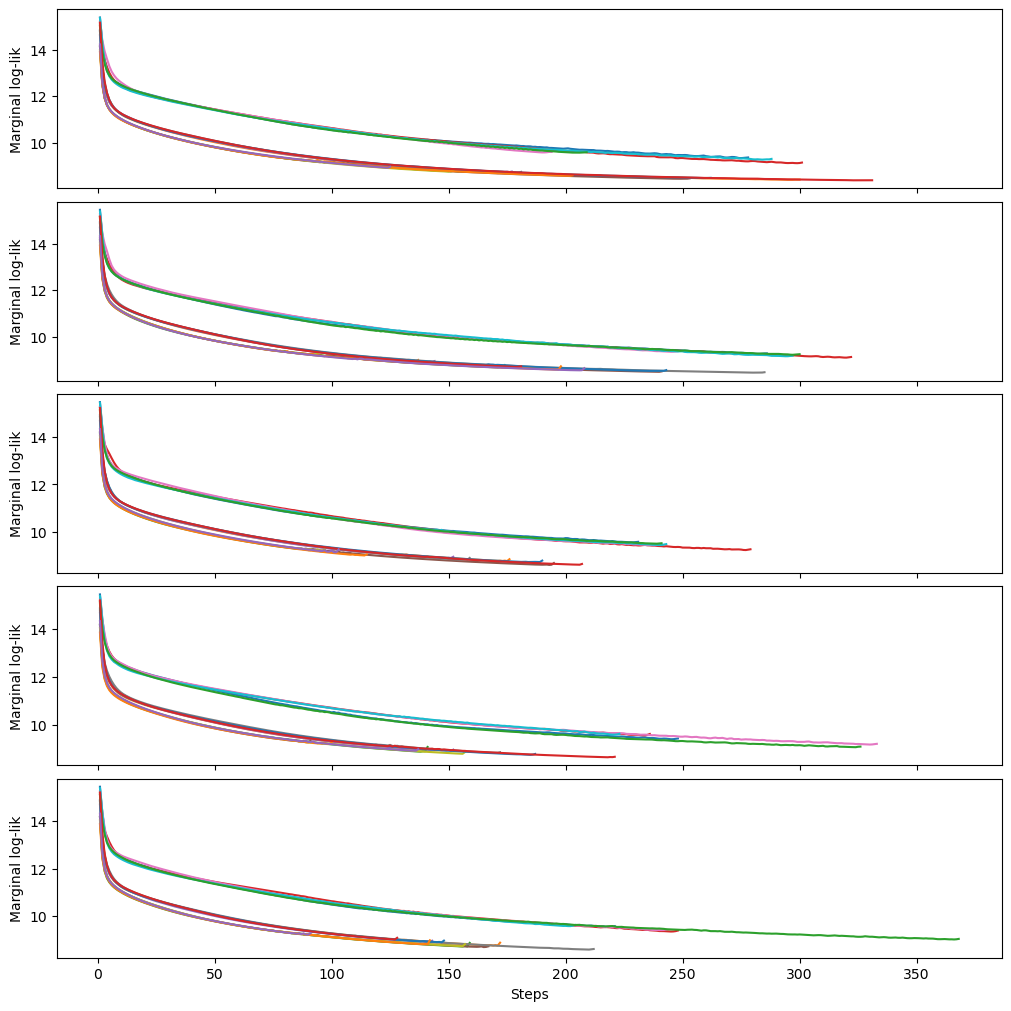

In [20]:
f,axs = plt.subplots(n_folds,1,constrained_layout=True,figsize=(10,2*n_folds), sharex=True)
for fold_i,ax in zip(range(n_folds), axs):
    for gp_i in gp_index[gp_index.get_locs(pd.IndexSlice[fold_i,:,:])]:
        ax.plot([r.step for r in optimization_trace[gp_i]], [r.fval for r in optimization_trace[gp_i]])
    ax.set_ylabel('Marginal log-lik');
axs.flat[-1].set_xlabel('Steps');
plt.show(f);plt.close(f)
# print(optimization_trace[-1].status, optimization_trace[-1].message)

## Metrics

In [21]:
metrics = pd.DataFrame(columns=['acc','auc'],index=gp_index)

In [22]:
n_plots = n_folds
n_cols = 5
n_rows = int(np.ceil(n_plots / n_cols))
# f,axs = plt.subplots(n_rows,n_cols, sharey=True, sharex=True, figsize=(n_cols*4, n_rows*4))
for fold_i in fold_index:
    train_idx, test_idx = idx_splits[fold_i]
    test_classes = all_classes[test_idx]
    test_embeddings = all_embeddings[test_idx]
    for gp_i in gp_index[gp_index.get_locs(pd.IndexSlice[fold_i,:,:])]:
        model = models[gp_i]
        model.eval()
        with torch.no_grad():
            test_pred_dist = model(test_embeddings)

        test_pred_samples = test_pred_dist.sample(torch.Size((256,))).exp()
        test_probabilities = (test_pred_samples / test_pred_samples.sum(1, keepdim=True)).mean(0)
        test_pred_class = torch.argmax(test_probabilities,dim=0,keepdim=False)

        acc = sklearn.metrics.accuracy_score(test_classes, test_pred_class)
        auc = sklearn.metrics.roc_auc_score(test_classes,test_probabilities.T,multi_class="ovo")
        metrics.at[gp_i, 'acc'] = acc
        metrics.at[gp_i, 'auc'] = auc

        # disp = sklearn.metrics.ConfusionMatrixDisplay(
        #     sklearn.metrics.confusion_matrix(test_classes, test_pred_class),
        #     display_labels=class_labels
        # )
        # axs.flat[fold_i].set_title(f'Fold {fold_i+1:02d} (ACC: {acc*100:0.2f} AUC: {auc:0.2f})')
        # disp.plot(ax=axs.flat[fold_i], colorbar=False);

/home/sentr/bin/miniconda/envs/gpytorch/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/sentr/bin/miniconda/envs/gpytorch/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/sentr/bin/miniconda/envs/gpytorch/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/sentr/bin/miniconda/envs/gpytorch/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/sentr/bin/miniconda/envs/gpytorch/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/sentr/bin/miniconda/envs

In [25]:
print('Metrics')
display(metrics.apply(lambda y: f'{y.mean():0.2f} ± {2*y.std():0.2f}').to_frame().T)
print('Metrics by latent dimension')
display(metrics.groupby(level=[2]).apply(lambda x: x.apply(lambda y: f'{y.mean():0.2f} ± {2*y.std():0.2f}')))

Metrics


,acc,auc
0,0.70 ± 0.09,0.84 ± 0.12


Metrics by latent dimension


,acc,auc
dim_i,,
2,0.64 ± 0.04,0.76 ± 0.03
5,0.72 ± 0.05,0.87 ± 0.04
10,0.74 ± 0.05,0.89 ± 0.04
